# Week 3 Project - Cancer Detection

Hello! Welcome to my project using the cancer detection image classification kaggle competition. Cancer detection is critical in our modern world, as it continues to be a leading killer across the world. In this project, we will explore pathology slides and identify whether metastatic cancer is present in the image. We will train a convolutional neural network as we developed in class and use the 220,000 image training data set to train and tweak this model. Then, we will evaluate the test dataset using testing images in the kaggle competition. Thank you for joining me as we exlpore this critical piece of classification.

First we will import our data from kaggle and perform some exploratory data analysis. Using the kaggle package, we can port the information directly from kaggle due to the large size of the data and associated issues with upload efficiency.
The below chunks load our training labels, training images, testing images, and sample submission. Please join me as we discuss our findings below.

In [4]:
!pip install kaggle


In [1]:
import os
os.listdir('/content')

['.config', 'kaggle.json', 'sample_data']

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [01:18<00:00, 68.5MB/s]
100% 6.31G/6.31G [01:18<00:00, 86.0MB/s]


In [4]:
import zipfile

zip_file_path = '/content/histopathologic-cancer-detection.zip'

extracted_dir_path = '/content/dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [5]:
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Activation,BatchNormalization, ReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection  import train_test_split

# EDA

This section of the report will focus on our training and test datasets. Follow along in the next chunks to analyze the data. Our training labels dataset comes with the label name for each image in the dataset. Each image is a .tif file with 96x96 pixels. We will be examining the center 32x32 pixels for signs of cancer. Our training set has 220,025 images while our test set has 57,458 images. The training set comes with labels for training on whether the sample has cancer or not. The test set does not have labels, a field which we will predict. In order to view the images, we can access the image file using the directory and .tif extension. The following chunks display the processes and images. Please join below for more discussion.

In [6]:
train_labels = pd.read_csv('/content/dataset/train_labels.csv')
sample_submission = pd.read_csv('/content/dataset/sample_submission.csv')

In [7]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
train_labels.shape

(220025, 2)

In [24]:
sample_submission.head()


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [9]:
sample_submission.shape

(57458, 2)

In [10]:
path = '/content/dataset/train/'
filepath = path + train_labels['id'] + '.tif'
testpath = '/content/dataset/test/'
testpaths = testpath + sample_submission['id'] + '.tif'

In [28]:
testpaths.head()

0    /content/dataset/test/0b2ea2a822ad23fdb1b5dd26...
1    /content/dataset/test/95596b92e5066c5c52466c90...
2    /content/dataset/test/248e6738860e2ebcf6258cdc...
3    /content/dataset/test/2c35657e312966e9294eac68...
4    /content/dataset/test/145782eb7caa1c516acbe2ed...
Name: id, dtype: object

In [12]:
filepath.head()

0    /content/dataset/train/f38a6374c348f90b587e046...
1    /content/dataset/train/c18f2d887b7ae4f6742ee44...
2    /content/dataset/train/755db6279dae599ebb4d39a...
3    /content/dataset/train/bc3f0c64fb968ff4a8bd33a...
4    /content/dataset/train/068aba587a4950175d04c68...
Name: id, dtype: object

In [11]:
train_labels['path'] = filepath
test = pd.DataFrame()
test['path'] = testpaths

In [13]:
from PIL import Image
import os

def load_image(file_path):
    image = Image.open(file_path)
    return image

train_labels['image'] = train_labels['path'].apply(load_image)

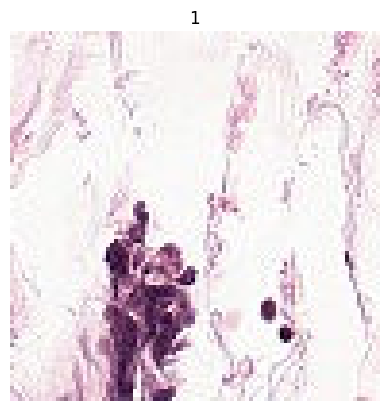

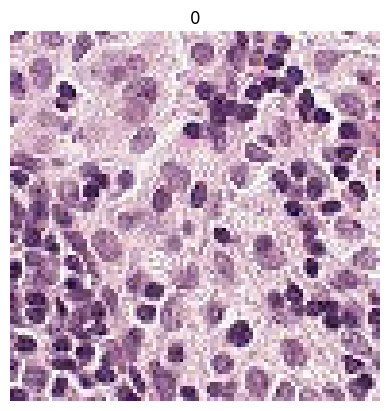

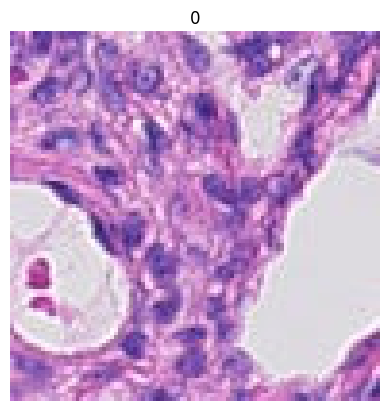

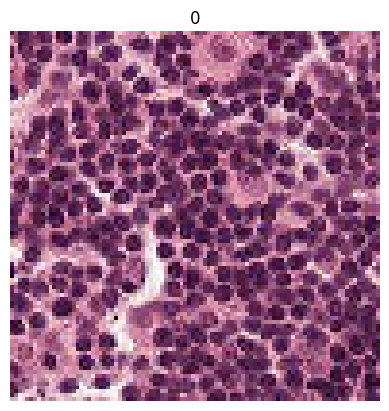

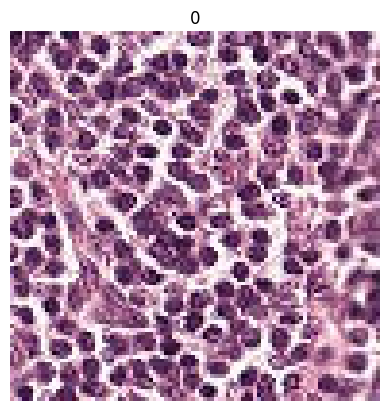

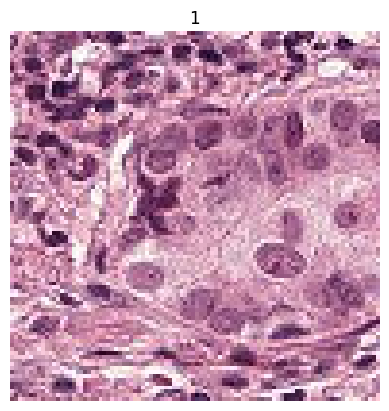

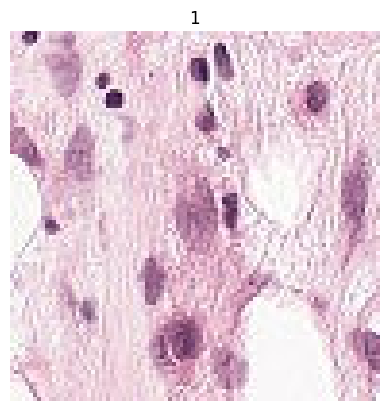

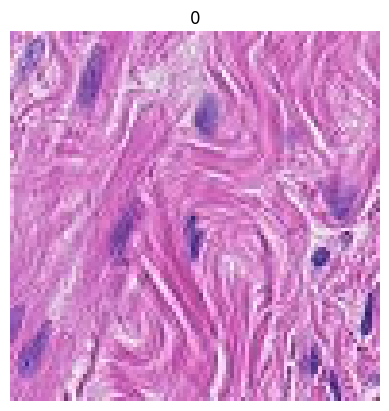

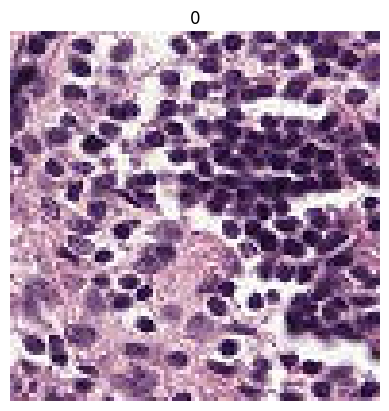

In [16]:
import matplotlib.pyplot as plt

for i in range(1,10):
  plt.imshow(train_labels['image'][i])
  plt.title(train_labels['label'][i])
  plt.axis('off')
  plt.show()

In the above array of images, we can see the pathology slide along with its label, 1 for cancerous and 0 for no cancer. While I have a limited biology background and find it difficult to visually identify where the cancer is it may appear that the cancerous samples contain more darker spots/masses in the middle. Because it is quite difficult to highlight where the cancer is, a CNN provides the perfect opportunity to identify features and identify whether cancer is present based on these features, beating out an untrained human. Perhaps a biologist could spot cancer, but a CNN provides an excellent opportunity to help identify cancer from an untrained eye.

Exploring the data further, we see below we have a fairly even breakout between our labels, with 130,908 samples identified as non-cancerous and 89,117 samples as cancerous. Because the dataset is balanced, we do not need to take action to correct our balance when evaluating accuracy. When training our CNN, we will want to confirm we are not overfitting the data, so in the following chunks we create a training set and a validation set from our original dataset. This will allow us to monitor overfitting during development and monitor our accuracy. The next chunks create a training and validation set and explore the breakout of cancer vs. no cancer in our dataset.

In [17]:
train_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

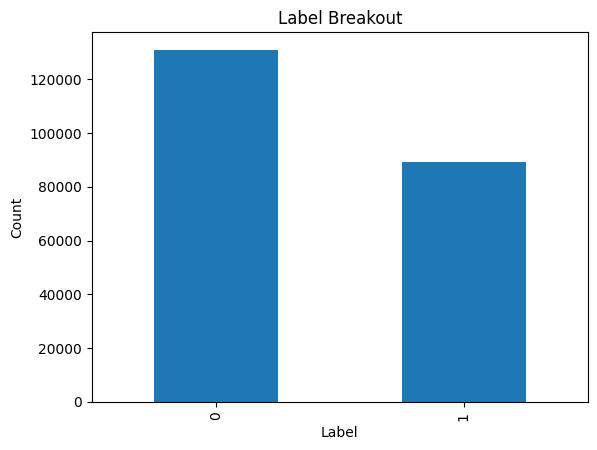

In [18]:

train_labels['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Breakout')
plt.show()


In [12]:
train, val = train_test_split(train_labels, test_size=0.2)


In [32]:
train['label'] = train['label'].astype(str)
val['label'] = val['label'].astype(str)


In [38]:
datagen = ImageDataGenerator(
    rescale=1./255,

)

train_gen = datagen.flow_from_dataframe(train,
                                        x_col = 'path',
                                      y_col = 'label',
                                        target_size=(96,96),
                                        batch_size=32,
                                        class_mode='binary')

val_gen = datagen.flow_from_dataframe(val,
                                      x_col = 'path',
                                      y_col = 'label',

                                        target_size=(96,96),
                                        batch_size=32,
                                        class_mode='binary')
test_gen = datagen.flow_from_dataframe(test,
                                       x_col = 'path',
                                       target_size=(96,96),
                                        batch_size=32,
                                        class_mode=None
                                       )

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


The above code chunk is our final preprocessing step. Because the CNN takes numerical input, we must feed in numpy arrays representing the pixel values. The code above generates a 96x96x3 array for each image in the training, validation, and test set, representing each pixel and its RGB values. This is our final preprocessing step as now all three sets are prepared for a convolutional neural net to classify cancer images.

# Model Architecture

Now that our data is prepared and analyzed, we can begin to develop our model architecture. Using concepts from class we can see the optimal structure developed below. We use a keras sequential model, and having several filtering convolution layers and a pooling layer, before repeating. Then the convolution data is fed into a regular neural network from where we predict the class of the pathology slide.

This architecture went through several phases before reaching this final presentation. We will discuss the performance of each iteration later on, but I wanted to highlight some optimization techniques in the architecture I found to be useful in this dataset. Using 3 convolution-pooling layers was key, instead of 2 or 4 of these layers. Increasing the number of filters in each convolution section was also powerful. Another key point was to use dropout layers as this helped improve performance, whereas the use of batch normalization did not contribute significantly to accuracy improvements. Using a ReLU activation after each convolution layer also contributed signficantly to predictive accuracy. To begin, I started with a large number of filters, but decreasing the number of filters helped significantly.

Finally, as discussed in class, the Adam optimizer helped significantly with performance, and using a small learning rate of 0.001 was very useful. Please see the full architecture below.

In [79]:
model = Sequential()
model.add(Conv2D(25, (3,3), activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(25, (3,3), activation = 'relu'))
model.add(Conv2D(25, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(50, (3,3), activation = 'relu'))
model.add(Conv2D(50, (3,3), activation = 'relu'))
model.add(Conv2D(50, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(100, (3,3), activation = 'relu'))
model.add(Conv2D(100, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(96, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation = "sigmoid"))

opt = Adam(0.001)
model.compile(opt, loss = "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 94, 94, 25)        700       
                                                                 
 conv2d_50 (Conv2D)          (None, 92, 92, 25)        5650      
                                                                 
 conv2d_51 (Conv2D)          (None, 90, 90, 25)        5650      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 45, 45, 25)        0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 45, 45, 25)        0         
                                                                 
 conv2d_52 (Conv2D)          (None, 43, 43, 50)        11300     
                                                      

Next, we can use the model generator to fit our model, in total we fit seven iterations of the model. Using early stopping, we cease training when the validation accuracy begins to decrease, signaling overfitting. This helps to speed up training, and in total we were able to train seven iterations, at about 30 minutes per run. Below are our training accuracy of 87% and validation accuracy of 89%. Of all iterations, this proved most efficient, utilizing the architecture described above.

In [80]:
from keras.callbacks import EarlyStopping

train_steps_per_epoch = len(train_gen)
val_steps_per_epoch = len(val_gen)

early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

history = model.fit_generator(train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=val_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping]
)

Epoch 1/10


<ipython-input-80-bc153355c080>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


5501/5501 [==============================] - 427s 76ms/step - loss: 0.4474 - accuracy: 0.8033 - val_loss: 0.5672 - val_accuracy: 0.6940
Epoch 2/10
5501/5501 [==============================] - 405s 74ms/step - loss: 0.3541 - accuracy: 0.8501 - val_loss: 0.3554 - val_accuracy: 0.8413
Epoch 3/10
5501/5501 [==============================] - 384s 70ms/step - loss: 0.3171 - accuracy: 0.8689 - val_loss: 0.2698 - val_accuracy: 0.8901
Epoch 4/10
5501/5501 [==============================] - 426s 77ms/step - loss: 0.2938 - accuracy: 0.8815 - val_loss: 0.2851 - val_accuracy: 0.8819


In total seven iterations were used:
1. 4 Pooling layers and one dense layer, using limited activation layers, and high number of filters. Validation accuracy of 60%.
2. 4 Pooling layers and two dense layers, using limited activation functions, batch normalization, high number of filters. Validation accuracy of 78%.
3. 3 pooling layers and two dense layers, limited activation functions and batch normalization, lower number of filters. Validation accuracy of 81%.

Lower Learning Rate to 0.001.
4. 3 pooling layers and two dense layers, limited activation functions and dropout layers, lower number of filters. Validation accuracy of 84%.
5. 3 pooling layers and two dense layers, more reLU activation functions and dropout layers, lower number of filters. Validation accuracy of 86%.
6. 3 pooling layers and two dense layers, all reLU activation functions and dropout layers and batch normalization, lower number of filters. Validation accuracy of 85%.
7. Current architecture above. Validation accuracy of 89%.

In summary, learning rate optimization and drop out layers with activation functions are very key and allowed us to optimize the prediction accuracy. The following steps prepare the test data and run the model on our test generated images. Then we export to csv and submit to kaggle. The current architecture was best and netted a 87% accuracy in the test kaggle competition.

In [93]:
preds = model.predict_generator(test_gen)


<ipython-input-93-76aa4a06c518>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


In [92]:
testfile = test_gen.filenames


In [86]:
testtrim = []
for test in testfile:
  testtrim.append(test.split('/')[-1].split('.'))
first_values = [sublist[0] for sublist in testtrim]


In [95]:
preds

array([[0.76571524],
       [0.75831157],
       [0.8554946 ],
       ...,
       [0.9985643 ],
       [0.02265812],
       [0.02043519]], dtype=float32)

In [73]:
submission = pd.DataFrame()

In [118]:
submission['id'] = first_values
submission['label'] = preds

In [119]:
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.765715
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.758312
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.855495
3,2c35657e312966e9294eac6841726ff3a748febf,0.423010
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.432547


In [110]:
submission.to_csv('submission.csv', index = False)

With an accuracy of 87% on the test data in kaggle, our model certainly poses strong prediction accuracy. We can efficiently use our model in the real world, providing a quality estimate on the cancer diagnosis, and when used in conjunction with a doctor or biologist, we can identify cancer efficiently. Using the architecture described above, we are able to accurately describe cancer samples. Others in the competition scored much higher, and I believe with further testing and training of the model, I could make improvements too. Because each model takes 30 minutes plus, due to my busy schedule I could not train more models. In the future I would want to test more architectures and hyperparameter tuning with stronger equipment and more time. I believe the key to solving this problem most accurately is more trial and error with powerful graphics cards. I learned a lot from this week and the project itself, using neural networks with convolution is very powerful and a creative approach to the problem. Dropout layers, activation functions, and learning rates are critical, at least in this example, and the more complex a model does not mean more powerful. It is a good reminder of how simple mechanisms can often be most powerful. I learned some amazing hands on skills in this lesson/project and can't wait to classify more images in the future. Thanks for joining me today!